# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Tensorboard support

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2022-02-03 13:51:18--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 18.205.222.128, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.19M  36.7MB/s    in 0.4s    

2022-02-03 13:51:18 (36.7 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13832437/13832437]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.7/json/__init__.py", line 296, in load
    parse_constant=parse_constant, object_pairs_hook=object_pairs_hook, **kw)
  File "/usr/lib/python3.7/json/__init__.py", line 348, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.7/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.7/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)



KeyboardInterrupt



## Perform imports

In [ ]:
#!pip install tensorflow_addons

In [ ]:
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import itertools
import numpy as np
import random
import pandas as pd
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D,Flatten,Dense, Dropout, BatchNormalization, Add, AveragePooling3D, Activation, GaussianNoise, Lambda
from tensorflow.keras import optimizers, losses, regularizers
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.utils import plot_model, Sequence
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD
from IPython.display import SVG
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from tqdm import tqdm, trange
import tensorflow as tf
import os

## Define util functions

In [ ]:
# Reads a up to spec pdb file and return a tuple of the
# atoms' x, y, z and atomtype
def read_pdb(filename):
    with open(filename, 'r') as file:
        strline_L = file.readlines()
    atom_list = []
    for strline in strline_L:
        # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
        stripped_line = strline.strip()

        line_length = len(stripped_line)
        # print("Line length:{}".format(line_length))
        if line_length < 78:
            print("ERROR: line length is different. Expected>=78, current={}".format(line_length))
        
        atom_list.append((
            stripped_line[30:38].strip(),
            stripped_line[38:46].strip(),
            stripped_line[46:54].strip(),
            'h' if stripped_line[76:78].strip() == 'C' else 'p',
        ))
        
    return np.array(atom_list, order='F')

In [ ]:
# Reads the test pdb file and return a tuple of the
# atoms' x, y, z and atomtype
def read_test_pdb(filename):
    with open(filename, 'r') as file:
        strline_L = file.readlines()
    atom_list = []
    for strline in strline_L:
        # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
        stripped_line = strline.strip()
        tokens = stripped_line.split("\t")
        
        atom_list.append((
            tokens[0],
            tokens[1],
            tokens[2],
            tokens[3],
        ))

    return np.array(atom_list, order='F')

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
def mcc(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def ppv(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = tp
    denominator = tp + fp

    return numerator / (denominator + K.epsilon())

def tpr(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = tp
    denominator = tp + fn

    return numerator / (denominator + K.epsilon())


# Import raw training data

## Download and unzip the training data

In [ ]:
!curl -O https://noname-1256719566.cos.ap-nanjing.myqcloud.com/project.zip
!unzip project.zip

## Load training data into memory

In [ ]:
raw_training_data = {
    'pro': [],
    'lig': []
}
for i in trange(3000):
    raw_training_data['pro'].append(
        read_pdb("project/training_data/{:04d}_pro_cg.pdb".format(i + 1)))
    raw_training_data['lig'].append(
        read_pdb("project/training_data/{:04d}_lig_cg.pdb".format(i + 1)))

100%|██████████| 3000/3000 [00:10<00:00, 282.34it/s]


In [ ]:
n = int(len(raw_training_data['pro'])*0.9)
raw_training_train_data = {
    'pro': raw_training_data['pro'][:n],
    'lig': raw_training_data['lig'][:n]
}
raw_training_test_data = {
    'pro': raw_training_data['pro'][n:],
    'lig': raw_training_data['lig'][n:]
}

In [ ]:
# raw_training_data

# Preprocess training data

## Install multidimensional sparse matrix library

In [ ]:
!pip install sparse

     |████████████████████████████████| 77 kB 3.2 MB/s 


In [ ]:
from sparse import COO
import sparse

## Define voxelization functions

In [ ]:
# Returns a sparse matrix representation of the voxel
def voxelize(pdb_inputs, max_dist=20, grid_resolution=4):
    def featurize(atom_type):
        # Default: protein, hydrophobic
        feat = [0, 128]
        # Change to ligand
        if atom_type[1] == 'l':
            feat[0] = 1
        # change to polar
        if atom_type[0] == 'p':
            feat[1] = 256
        return feat
    
    max_dist = float(max_dist)
    grid_resolution = float(grid_resolution)
    box_size = np.ceil(2 * max_dist / grid_resolution + 1)

    # merge protein and ligand
    pro_atoms = pdb_inputs[0]
    lig_atoms = pdb_inputs[1]
    pro_atoms = np.c_[pro_atoms, np.full(pro_atoms.shape[0], 'p')]
    lig_atoms = np.c_[lig_atoms, np.full(lig_atoms.shape[0], 'l')]
    all_atoms = np.r_[pro_atoms, lig_atoms]

    # center all atoms around the center of the protein
    coord_mat = all_atoms[:,:3].astype(np.float)
    coord_mat = coord_mat - np.mean(lig_atoms[:,:3].astype(np.float), axis=0)

    # add feature list to identify the atom h/p and pro/lig
    feats_list = np.asarray([featurize(atom_type) for atom_type in all_atoms[:,-2:]])  
    atom_mat = np.c_[coord_mat, feats_list]

    # move all atoms to the nearest grid point
    atom_mat = np.c_[coord_mat, feats_list]
    atom_mat[:,:3] = (atom_mat[:,:3] + max_dist) / grid_resolution
    atom_mat[:,:3] = atom_mat[:,:3].round()
    atom_mat = atom_mat.astype(int)

    # remove atoms outside the box
    in_box = ((atom_mat[:,:3] >= 0) & (atom_mat[:,:3] < box_size)).all(axis=1)
    atom_mat = atom_mat[in_box]

    # transpose the matrix
    feats_list = np.squeeze(atom_mat[:,-1:])
    atom_mat = atom_mat[:,:4].T
    
    # create the sparse matrix
    s = COO(atom_mat, feats_list, shape=(int(box_size), int(box_size), int(box_size), 2))
    s.sum()
    s = s.reshape((1, int(box_size), int(box_size), int(box_size), 2))
    
    return s

In [ ]:
# Returns a tuple containg the training data and corresponding labels
# ratio specifies the number of negative training examples generated
# per positive training example
def generate_training_data(raw_data, pos_ratio=1, neg_ratio=1, max_dist=20, grid_resolution=4, quiet=False):
    n = len(raw_data['pro'])
    x_all = []
    y_all = []
    for i in tqdm(range(n), disable=quiet):
        for _ in range(pos_ratio):
            grid = voxelize((
                raw_data['pro'][i],
                raw_data['lig'][i]
            ), max_dist, grid_resolution)
            x_all.append(grid)
            y_all.append([1.])
        for _ in range(neg_ratio):
            grid = voxelize((
                raw_data['pro'][i],
                raw_data['lig'][random.choice(list(range(i)) + list(range(i+1, n)))]
            ), max_dist, grid_resolution)
            x_all.append(grid)
            y_all.append([0.])
    return sparse.concatenate(x_all), np.asarray(y_all)

## Define Keras Sequence for dymanically generating samples



In [ ]:
class ProLigSequence(Sequence):

    def __init__(self, raw_data, max_dist=20, grid_resolution=4, batch_size=128, neg_ratio=1, quiet=True, sparse=True):
        self.raw_data = raw_data
        self.max_dist = max_dist
        self.grid_resolution = grid_resolution
        self.batch_size = batch_size
        self.neg_ratio = neg_ratio
        self.quiet = quiet
        self.sparse = sparse
        self.pos_eg_x, self.pos_eg_y = generate_training_data(raw_data, neg_ratio=0, max_dist=max_dist, grid_resolution=grid_resolution, quiet=self.quiet)
        if not sparse:
            self.pos_eg_x = self.pos_eg_x.todense()
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.all_eg_x) / float(self.batch_size)))

    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x = self.all_eg_x[indexes].todense() if self.sparse else self.all_eg_x[indexes]
        batch_y = self.all_eg_y[indexes]
        return batch_x, batch_y

    def on_epoch_end(self):
        # Generate a new set of negative training examples
        self.neg_eg_x, self.neg_eg_y = generate_training_data(
            self.raw_data,
            pos_ratio=0,
            neg_ratio=self.neg_ratio,
            max_dist=self.max_dist,
            grid_resolution=self.grid_resolution,
            quiet=self.quiet
        )
        if self.sparse:
            self.all_eg_x = sparse.concatenate((self.pos_eg_x, self.neg_eg_x))
        else:
            self.all_eg_x = np.concatenate((self.pos_eg_x, self.neg_eg_x.todense()))
        self.all_eg_y = np.concatenate((self.pos_eg_y, self.neg_eg_y))
        self.indexes = np.arange(len(self.all_eg_x))
        np.random.shuffle(self.indexes)

# Define Wide ResNet

In [ ]:
# k defines the width of the network as defined in the Wide ResNet paper
def generate_resnet(input_shape, k=1, noise=False,
                    l1_filters=16, l1_kernel_size=3, l1_dilation_rate=1):
    inputs = Input(shape=input_shape)
    x = inputs
    x = Conv3D(
        filters=l1_filters,
        kernel_size=l1_kernel_size,
        dilation_rate=l1_dilation_rate,
        padding='valid',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    
    # Block 1.1 32 Features
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x2 = Conv3D(
        filters=32*k,
        kernel_size=1,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    x1 = Conv3D(
        filters=32*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=32*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x = Add()([x1, x2])

    # Block 1.2 32 Features
    x2 = x
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=32*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=32*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x = Add()([x1, x2])

    # Block 2.1 64 Features
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x2 = Conv3D(
        filters=64*k,
        kernel_size=1,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    x1 = Conv3D(
        filters=64*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=64*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x = Add()([x1, x2])

    # Block 2.2 64 Features
    x2 = x
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=64*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=64*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x = Add()([x1, x2])    
    
    # Block 3.1 128 Features
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x2 = Conv3D(
        filters=128*k,
        kernel_size=1,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    x1 = Conv3D(
        filters=128*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=128*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x = Add()([x1, x2])

    # Block 3.2 128 Features
    x2 = x
    x1 = BatchNormalization()(x)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=128*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x1 = Dropout(0.5)(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv3D(
        filters=128*k,
        kernel_size=3,
        padding='same',
        data_format='channels_last',
        kernel_initializer='he_normal',
    )(x1)
    x = Add()([x1, x2])      
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = AveragePooling3D()(x)
    x = Flatten()(x)
    x = Dense(
        128,
        activation='relu',
        kernel_initializer='he_normal',
    )(x)
    x = Dropout(0.5)(x)
    outputs = Dense(
        1,
        activation='sigmoid',
        kernel_initializer='he_normal',
    )(x)

    return Model(inputs=inputs, outputs=outputs)


In [ ]:
model = generate_resnet(
    input_shape=(21, 21, 21, 2),
    k=1,
    l1_filters=16,
    l1_kernel_size=6,
    l1_dilation_rate=3,
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 21, 21, 21,  0           []                               
                                 2)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 6, 6, 6, 16)  6928        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 6, 6, 6, 16)  64         ['conv3d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
model.compile(
    loss='binary_crossentropy',
    metrics=['accuracy', 'loss', 'val_accuracy', 'val_loss'],
    optimizer=Adam()
)

In [ ]:
gen = ProLigSequence(raw_training_train_data, batch_size=512, max_dist=40, grid_resolution=4, sparse=False)

In [ ]:
val = ProLigSequence(raw_training_test_data, batch_size=512, max_dist=40, grid_resolution=4, sparse=False)

In [ ]:
def mcc(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def ppv(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = tp
    denominator = tp + fp

    return numerator / (denominator + K.epsilon())

def tpr(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = tp
    denominator = tp + fn

    return numerator / (denominator + K.epsilon())


In [ ]:
model.compile(
    loss='binary_crossentropy',
    metrics=['acc', mcc, ppv, tpr],
    optimizer=Adam())

In [ ]:
history = model.fit(
    ProLigSequence(raw_training_train_data, batch_size=512, max_dist=40, grid_resolution=4, sparse=False),
    validation_data=ProLigSequence(raw_training_test_data, batch_size=512, max_dist=40, grid_resolution=4, sparse=False),
    epochs=50,
    initial_epoch=0,
    use_multiprocessing=True,
    workers=8,
    callbacks=[ModelCheckpoint('/content/drive/MyDrive/BS6207/project/best_model_val_acc.h5',
                           monitor='val_acc',
                           verbose=1,
                           save_best_only=True,
                           mode='max'),
              TensorBoard()])

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 0.7495 - acc: 0.7350 - mcc: 0.5049 - ppv: 0.8045 - tpr: 0.7057 
Epoch 00001: val_acc improved from -inf to 0.50000, saving model to Dynamic.h5
11/11 [==============================] - 388s 35s/step - loss: 0.7495 - acc: 0.7350 - mcc: 0.5049 - ppv: 0.8045 - tpr: 0.7057 - val_loss: 259.6487 - val_acc: 0.5000 - val_mcc: 0.0000e+00 - val_ppv: 0.5188 - val_tpr: 1.0000
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 0.2185 - acc: 0.9233 - mcc: 0.8512 - ppv: 0.8902 - tpr: 0.9673 
Epoch 00002: val_acc improved from 0.50000 to 0.52667, saving model to Dynamic.h5
11/11 [==============================] - 379s 34s/step - loss: 0.2185 - acc: 0.9233 - mcc: 0.8512 - ppv: 0.8902 - tpr: 0.9673 - val_loss: 53.4533 - val_acc: 0.5267 - val_mcc: 0.1896 - val_ppv: 0.5055 - val_tpr: 1.0000
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 0.2088 - acc: 0.9280 - mcc: 0.8614 - ppv: 0.8882 - tpr: 0.9804 
Ep

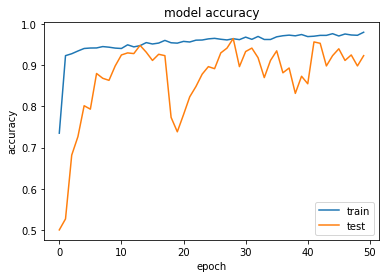

In [ ]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

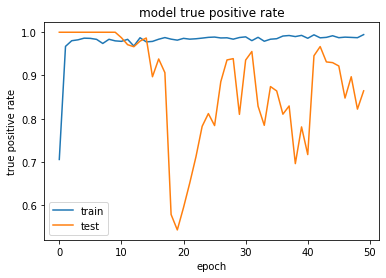

In [ ]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize history for accuracy
plt.plot(history.history['tpr'])
plt.plot(history.history['val_tpr'])
plt.title('model true positive rate')
plt.ylabel('true positive rate')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

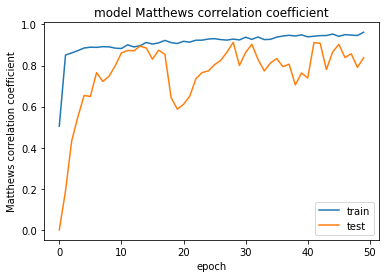

In [ ]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize history for accuracy
plt.plot(history.history['mcc'])
plt.plot(history.history['val_mcc'])
plt.title('model Matthews correlation coefficient')
plt.ylabel('Matthews correlation coefficient')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

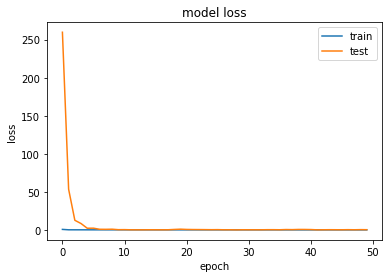

In [ ]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

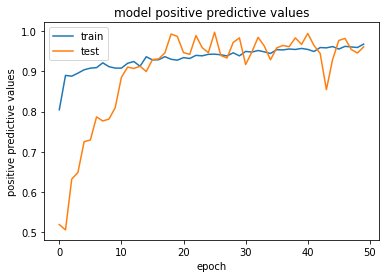

In [ ]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

# summarize history for accuracy
plt.plot(history.history['ppv'])
plt.plot(history.history['val_ppv'])
plt.title('model positive predictive values')
plt.ylabel('positive predictive values')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [ ]:
history = model.fit(
    ProLigSequence(raw_training_train_data, batch_size=512, max_dist=40, grid_resolution=4, sparse=False),
    validation_data=ProLigSequence(raw_training_test_data, batch_size=512, max_dist=40, grid_resolution=4, sparse=False),
    epochs=20,
    initial_epoch=0,
    use_multiprocessing=True,
    workers=8,
    callbacks=[ModelCheckpoint('/content/drive/MyDrive/BS6207/project/best_model_val_tpr.h5',
                           monitor='val_tpr',
                           verbose=1,
                           save_best_only=True,
                           mode='max')])

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 0.0671 - acc: 0.9822 - mcc: 0.9652 - ppv: 0.9743 - tpr: 0.9912 
Epoch 00001: val_tpr improved from -inf to 0.91503, saving model to /content/drive/MyDrive/BS6207/project/best_model_val_tpr.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


11/11 [==============================] - 457s 41s/step - loss: 0.0671 - acc: 0.9822 - mcc: 0.9652 - ppv: 0.9743 - tpr: 0.9912 - val_loss: 0.3466 - val_acc: 0.9350 - val_mcc: 0.9079 - val_ppv: 0.9890 - val_tpr: 0.9150
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.0765 - acc: 0.9789 - mcc: 0.9574 - ppv: 0.9656 - tpr: 0.9923 
Epoch 00002: val_tpr improved from 0.91503 to 0.92940, saving model to /content/drive/MyDrive/BS6207/project/best_model_val_tpr.h5
11/11 [==============================] - 426s 39s/step - loss: 0.0765 - acc: 0.9789 - mcc: 0.9574 - ppv: 0.9656 - tpr: 0.9923 - val_loss: 0.2850 - val_acc: 0.9400 - val_mcc: 0.8827 - val_ppv: 0.9499 - val_tpr: 0.9294
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.0745 - acc: 0.9796 - mcc: 0.9601 - ppv: 0.9667 - tpr: 0.9941 
Epoch 00003: val_tpr did not improve from 0.92940
11/11 [==============================] - 416s 38s/step - loss: 0.0745 - acc: 0.9796 - mcc: 0.9601 - ppv: 0.9667 - tpr: 0.

In [ ]:
# The Matthews correlation coefficient (MCC) is more reliable than balanced accuracy, bookmaker informedness, and markedness in two-class confusion matrix evaluation
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7863449/

history = model.fit(
    ProLigSequence(raw_training_train_data, batch_size=512, max_dist=40, grid_resolution=4, sparse=False),
    validation_data=ProLigSequence(raw_training_test_data, batch_size=512, max_dist=40, grid_resolution=4, sparse=False),
    epochs=20,
    initial_epoch=0,
    use_multiprocessing=True,
    workers=8,
    callbacks=[ModelCheckpoint('/content/drive/MyDrive/BS6207/project/best_model_val_mcc.h5',
                           monitor='val_mcc',
                           verbose=1,
                           save_best_only=True,
                           mode='max')])

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 0.0508 - acc: 0.9846 - mcc: 0.9688 - ppv: 0.9729 - tpr: 0.9962 
Epoch 00001: val_mcc improved from -inf to 0.87419, saving model to /content/drive/MyDrive/BS6207/project/best_model_val_mcc.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


11/11 [==============================] - 407s 37s/step - loss: 0.0508 - acc: 0.9846 - mcc: 0.9688 - ppv: 0.9729 - tpr: 0.9962 - val_loss: 0.3265 - val_acc: 0.9433 - val_mcc: 0.8742 - val_ppv: 0.9873 - val_tpr: 0.8867
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.0720 - acc: 0.9800 - mcc: 0.9594 - ppv: 0.9684 - tpr: 0.9913 
Epoch 00002: val_mcc improved from 0.87419 to 0.92177, saving model to /content/drive/MyDrive/BS6207/project/best_model_val_mcc.h5
11/11 [==============================] - 404s 38s/step - loss: 0.0720 - acc: 0.9800 - mcc: 0.9594 - ppv: 0.9684 - tpr: 0.9913 - val_loss: 0.2291 - val_acc: 0.9567 - val_mcc: 0.9218 - val_ppv: 0.9787 - val_tpr: 0.9402
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 0.0580 - acc: 0.9850 - mcc: 0.9706 - ppv: 0.9743 - tpr: 0.9969 
Epoch 00003: val_mcc did not improve from 0.92177
11/11 [==============================] - 408s 37s/step - loss: 0.0580 - acc: 0.9850 - mcc: 0.9706 - ppv: 0.9743 - tpr: 0.

In [ ]:
history = model.fit(
    ProLigSequence(raw_training_train_data, batch_size=512, max_dist=40, grid_resolution=4, sparse=False),
    validation_data=ProLigSequence(raw_training_test_data, batch_size=512, max_dist=40, grid_resolution=4, sparse=False),
    epochs=20,
    initial_epoch=0,
    use_multiprocessing=True,
    workers=8,
    callbacks=[ModelCheckpoint('/content/drive/MyDrive/BS6207/project/best_model_val_ppv.h5',
                           monitor='val_ppv',
                           verbose=1,
                           save_best_only=True,
                           mode='max')])

# Evaluate Model

## Generate testing data

In [ ]:
len(raw_training_test_data)

2

In [ ]:
x_test, y_test = generate_training_data(raw_training_test_data, neg_ratio=0, max_dist=40, grid_resolution=4)
x_test = x_test.todense()

100%|██████████| 300/300 [00:04<00:00, 63.40it/s]


## Load best model

In [ ]:
dependencies = {'mcc':mcc, 'ppv':ppv, 'tpr':tpr}
best_model = load_model("Dynamic.h5", custom_objects=dependencies)

## Plot confusion matrix

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


Normalized confusion matrix
[[ nan  nan]
 [0.04 0.96]]


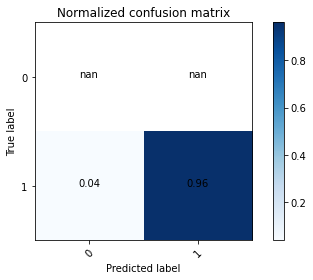

In [ ]:
y_pred = best_model.predict(x_test)
y_pred = np.piecewise(y_pred, [y_pred < 0.5, y_pred >= 0.5], [0., 1.])
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

In [ ]:
x_test[0].shape

(21, 21, 21, 2)

In [ ]:
results = best_model.predict(x_test)
results

In [ ]:
x_test.shape

(300, 21, 21, 21, 2)

In [ ]:
results.flatten().shape

(300,)

In [ ]:
(-results.flatten()).argsort()[:10]

In [ ]:
results

In [ ]:
results

In [ ]:
!ls "/content/project/testing_data_release/testing_data" | grep pro | wc -l

824


In [ ]:
read_test_pdb("project/testing_data_release/testing_data/{:04d}_pro_cg.pdb".format(pro_idx + 1))

array([['23.732', '52.847', '19.409', 'h'],
       ['23.481', '52.752', '17.931', 'h'],
       ['21.672', '50.355', '21.44', 'h'],
       ...,
       ['21.096', '24.697', '16.259', 'h'],
       ['20.265', '23.921', '15.241', 'h'],
       ['17.965', '21.322', '16.768', 'h']], dtype='<U6')

In [ ]:
results_list = []
for pro_idx in trange(10):
  raw_testing_data = {
    'pro': [],
    'lig': []
  }
  for lig_idx in range(824):
    raw_testing_data['pro'].append(
        read_test_pdb("project/testing_data_release/testing_data/{:04d}_pro_cg.pdb".format(pro_idx + 1)))
    raw_testing_data['lig'].append(
        read_test_pdb("project/testing_data_release/testing_data/{:04d}_lig_cg.pdb".format(lig_idx + 1)))
  x_test, y_test = generate_training_data(raw_testing_data, neg_ratio=0, max_dist=40, grid_resolution=4, quiet = True)
  x_test = x_test.todense()
  results = best_model.predict(x_test)
  ranks = np.argpartition(results.flatten(), 10)[:10]
  results_list.append(ranks)

100%|██████████| 10/10 [04:49<00:00, 28.91s/it]


In [ ]:
results_list

[array([221, 736, 230,  49, 623, 241,  95, 134, 407, 331]),
 array([226, 553, 655, 457, 359, 595,  11,  67, 503, 250]),
 array([761, 639, 562,  82, 638, 626, 340, 434, 739, 520]),
 array([248, 602, 667, 102, 757, 719, 276, 718, 779, 341]),
 array([790, 292, 817, 658, 589, 707,  91,   7, 327, 644]),
 array([230, 747, 163, 562, 206, 639, 649, 434, 209, 769]),
 array([648, 600, 799, 326, 388,  15, 738, 149, 437, 210]),
 array([670, 423,  59, 377, 448, 733,  87, 143, 210,  15]),
 array([354, 733, 725,  55, 154, 305, 653, 330, 322, 355]),
 array([ 13, 333, 325, 318, 317, 402,  76, 788, 166, 125])]

In [ ]:
results_list = []
for pro_idx in trange(824):
  raw_testing_data = {
    'pro': [],
    'lig': []
  }
  for lig_idx in range(824):
    raw_testing_data['pro'].append(
        read_test_pdb("project/testing_data_release/testing_data/{:04d}_pro_cg.pdb".format(pro_idx + 1)))
    raw_testing_data['lig'].append(
        read_test_pdb("project/testing_data_release/testing_data/{:04d}_lig_cg.pdb".format(lig_idx + 1)))
  x_test, y_test = generate_training_data(raw_testing_data, neg_ratio=0, max_dist=40, grid_resolution=4, quiet = True)
  x_test = x_test.todense()
  results = best_model.predict(x_test)
  ranks = np.argpartition(results.flatten(), 10)[:10]
  results_list.append(ranks)

In [ ]:
num = 1
with open('predictions.txt','w+') as f:
  f.write('pro_id	lig1_id	lig2_id	lig3_id	lig4_id	lig5_id	lig6_id	lig7_id	lig8_id	lig9_id	lig10_id\n')
  for ranks in rank_list:
    f.write(str(num))
    for rank in ranks:
      f.write('\t'+str(rank))
    f.write('\n')
    num+=1

In [ ]:
while True: time.sleep(10000)